In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import pickle

import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from IPython.display import display, HTML

from collections import defaultdict

from src.plot_utils import plot_sample, plot_history
from src.cfd import CFD
from src.cfd_utils import TIME_STEP, plot_diff_hist_stats, _get_gauss_stats

In [2]:
dataset = np.load(PWD + f'/data/dataset.npz', allow_pickle=True)

In [3]:
all_channels_data = dataset['dataset'].flat[0]
all_channels_data.keys()

dict_keys([8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [4]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

FILTERS_MULT_SEP = 4

# Utils

In [5]:
def plot_samples(X, y, y_pred, indices=[10, 11, 12, 13, 500, 1000, 2000, 3000]):
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        plot_sample(X[idx])
        plt.axvline(y[idx], c='red')
        plt.axvline(y_pred[idx], c='orange')
        
        diff = abs(y[idx] - y_pred[idx])
        plt.title(f'Diff: {diff:0.4f} ({diff * TIME_STEP:0.4f}) ns')
        
def plot_difference_hist(y_true, y_pred, channel, method, hist_range=(-2, 2), n_bins=100, return_gauss_stats=True):
    mu, std = plot_diff_hist_stats(y_true, y_pred, show=False, n_bins=n_bins, hist_range=hist_range, hist_label=f'', plot_gauss=True, return_gauss_stats=return_gauss_stats)

    plt.title(f'{method}. channel={channel}, mean={mu:0.3f}, std={std:0.3f}')
    return std
    
def train_model(model, X_train, y_train, X_test, y_test, lr=0.001, name='model', train=True, 
                n_epochs=1000, verbose=1, batch_size=2048, lr_patience=None, es_patience=None, 
                loss_weights=None):
    model.compile(loss='mse', optimizer=optimizers.Adam(lr), loss_weights=loss_weights)

    model_callbacks = []
    model_callbacks.append(callbacks.ModelCheckpoint(filepath=PWD + f'data/model_weights/nn_channels_experiments/{name}/weights', save_best_only=True, save_weights_only=True))
    if es_patience is not None:
        model_callbacks.append(callbacks.EarlyStopping(patience=es_patience))
    if lr_patience is not None:
        model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=lr_patience))
    
    if train:
        history = model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=model_callbacks).history
        pd.DataFrame(history).to_csv(PWD + f'data/model_weights/nn_channels_experiments/{name}/loss_log.csv')

    model.load_weights(PWD + f'data/model_weights/nn_channels_experiments/{name}/weights')
    history = pd.read_csv(PWD + f'data/model_weights/nn_channels_experiments/{name}/loss_log.csv')
    
    return history

def load_model(model, lr=0.001, name='model', loss_weights=None):
    model.compile(loss='mse', optimizer=optimizers.Adam(lr), loss_weights=loss_weights)
    model.load_weights(PWD + f'data/model_weights/nn_channels_experiments/{name}/weights')

In [6]:
def augmentation_random_cut(X, y, n_edge_cut=8, seed=None, apply=True):
    if not apply:
        return X[:, n_edge_cut:-n_edge_cut], y - n_edge_cut
    random_state = np.random.RandomState(seed)
    n_to_cut = n_edge_cut * 2
    
    start = random_state.randint(low=0, high=n_to_cut, size=X.shape[0])
    end = X.shape[1] - n_to_cut + start
    
    X_new = np.empty(shape=(X.shape[0], X.shape[1] - n_to_cut))
    for i in range(X.shape[0]):
        X_new[i] = X[i, start[i]:end[i]]
        
    y_new = y - start
    return X_new, y_new

In [7]:
def pred_and_retrieve_y(model, X):
    Y_heatmap = model.predict(X, batch_size=8192)
    y_pred = np.empty(len(X))
    for i, y in enumerate(Y_heatmap):
        try:
            y_pred[i] = _get_gauss_stats(y)
        except:
            # print(f'Error calculating {i}')
            y_pred[i] = np.average(np.arange(len(y)), weights=y)
    return y_pred

def compare_model_with_cfd(model, cfd, X, y_true, channel=None, figsize=(12, 4), show=True, y_cfd=None, return_gauss_stats=True, log=True):
    if y_cfd is None:
        y_cfd = np.array([cfd.predict(x) for x in X])
        n_none = list(y_cfd).count(None)
        if n_none > 0:
            print(f'--------------------> CFD returned {n_none} Nones out of {len(y_cfd)} examples')
    y_cfd = y_cfd.astype(np.float64)
    y_model = pred_and_retrieve_y(model, X)
    
    mask = y_cfd != None
    y_true = y_true[mask]
    y_cfd = y_cfd[mask]
    y_model = y_model[mask]
    
    if log and channel is not None:
        display(HTML(f'<h4>Channel {channel}</h4>'))
    
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    std_cfd = plot_difference_hist(y_true, y_cfd, channel, 'CFD', hist_range=(-6, 6), n_bins=300, return_gauss_stats=return_gauss_stats)
    plt.subplot(1, 2, 2)
    std_model = plot_difference_hist(y_true, y_model, channel, 'NN', hist_range=(-6, 6), n_bins=300, return_gauss_stats=return_gauss_stats)
    
    improvement = (std_cfd - std_model) / std_cfd
    
    if log:
        print(f"CFD: {std_cfd:0.3f}, NN: {std_model:0.3f} ({std_cfd * TIME_STEP:0.3f} ns vs {std_model * TIME_STEP:0.3f} ns)")
        print(f'Improvement: {improvement * 100:0.2f} %')
    if show:
        plt.show()
    else:
        plt.close()
    return improvement, std_cfd * TIME_STEP, std_model * TIME_STEP
    
cfd = CFD(n_baseline=10, fraction=0.25)

In [8]:
def bold(phrase):
    return '\033[1m' + phrase + '\033[0;0m'

# Models

In [9]:
def gaussian_kernel(mu, sigma=0.8, n=48):
    x = np.arange(0, n)
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

_get_gauss_stats(gaussian_kernel(np.array(1.6)))

1.6

In [10]:
def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    # skip = residual_block(x, n_filters, strides=1)
    x = layers.MaxPooling1D()(skip)
    return skip, x
    
def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    # x = residual_block(x, n_filters, strides=1)
    return x
    
    
###################################

def create_model(filters_mult=1):
    inputs = layers.Input(48)
    x = layers.Reshape((-1, 1))(inputs)

    skip1, x = conv_block(x, 8 * filters_mult)
    skip2, x = conv_block(x, 16 * filters_mult)
    skip3, x = conv_block(x, 32 * filters_mult)
    x, _ = conv_block(x, 64 * filters_mult)

    x = deconv_block(x, skip3, 32 * filters_mult)
    x = deconv_block(x, skip2, 16 * filters_mult)
    x = deconv_block(x, skip1, 8 * filters_mult)

    x = layers.Conv1D(1, 1, activation='linear')(x)

    outputs = layers.Flatten()(x)

    model = tf.keras.Model(inputs, outputs)
    return model

## Trained separately, tested on the same channels

In [11]:
improvements = {}
for channel, (X, y) in list(all_channels_data.items()):
    X_aug, y_aug = augmentation_random_cut(X, y, 8, seed=42, apply=True)
    X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])
    
    model = create_model(filters_mult=FILTERS_MULT_SEP)
    history = train_model(model, X_train, Y_heatmap_train, X_test, Y_heatmap_test, lr=0.001, name=f'model_separate_{channel}', 
                          train=False, n_epochs=200, verbose=0, loss_weights=100, lr_patience=20, es_patience=40)
    
    # plot_history(history, f"Channel {channel}, {len(X)} events", ymax=1, figsize=(10, 4))
    improvement, _, std_model = compare_model_with_cfd(model, cfd, X_test, y_test, channel, show=False)
    improvements[channel] = improvement, std_model

1/1 [==============================] - 2s 2s/step


CFD: 0.453, NN: 0.361 (0.071 ns vs 0.056 ns)
Improvement: 20.39 %
1/1 [==============================] - 0s 177ms/step


CFD: 0.458, NN: 0.399 (0.072 ns vs 0.062 ns)
Improvement: 12.97 %
1/1 [==============================] - 0s 206ms/step


CFD: 0.407, NN: 0.362 (0.064 ns vs 0.056 ns)
Improvement: 11.21 %
1/1 [==============================] - 0s 177ms/step


CFD: 0.423, NN: 0.358 (0.066 ns vs 0.056 ns)
Improvement: 15.24 %
1/1 [==============================] - 0s 388ms/step


CFD: 0.779, NN: 0.639 (0.122 ns vs 0.100 ns)
Improvement: 18.01 %
1/1 [==============================] - 0s 430ms/step


CFD: 0.751, NN: 0.604 (0.117 ns vs 0.094 ns)
Improvement: 19.59 %
1/1 [==============================] - 0s 440ms/step


CFD: 0.442, NN: 0.338 (0.069 ns vs 0.053 ns)
Improvement: 23.52 %
1/1 [==============================] - 0s 195ms/step


CFD: 0.459, NN: 0.373 (0.072 ns vs 0.058 ns)
Improvement: 18.71 %
1/1 [==============================] - 0s 250ms/step


CFD: 0.441, NN: 0.385 (0.069 ns vs 0.060 ns)
Improvement: 12.68 %
1/1 [==============================] - 0s 201ms/step


CFD: 0.560, NN: 0.481 (0.088 ns vs 0.075 ns)
Improvement: 14.25 %
1/1 [==============================] - 0s 168ms/step


CFD: 0.430, NN: 0.379 (0.067 ns vs 0.059 ns)
Improvement: 11.97 %
1/1 [==============================] - 0s 332ms/step


CFD: 0.427, NN: 0.390 (0.067 ns vs 0.061 ns)
Improvement: 8.75 %
1/1 [==============================] - 0s 222ms/step


CFD: 0.410, NN: 0.365 (0.064 ns vs 0.057 ns)
Improvement: 11.04 %
1/1 [==============================] - 0s 208ms/step


CFD: 0.409, NN: 0.361 (0.064 ns vs 0.056 ns)
Improvement: 11.70 %
2/2 [==============================] - 0s 69ms/step


CFD: 0.598, NN: 0.512 (0.093 ns vs 0.080 ns)
Improvement: 14.34 %
1/1 [==============================] - 0s 252ms/step


CFD: 0.683, NN: 0.620 (0.107 ns vs 0.097 ns)
Improvement: 9.15 %
1/1 [==============================] - 0s 440ms/step


CFD: 0.768, NN: 0.662 (0.120 ns vs 0.103 ns)
Improvement: 13.77 %
2/2 [==============================] - 0s 245ms/step


CFD: 0.709, NN: 0.570 (0.111 ns vs 0.089 ns)
Improvement: 19.56 %
1/1 [==============================] - 1s 522ms/step


CFD: 0.487, NN: 0.388 (0.076 ns vs 0.061 ns)
Improvement: 20.37 %
1/1 [==============================] - 0s 186ms/step


CFD: 0.444, NN: 0.388 (0.069 ns vs 0.061 ns)
Improvement: 12.73 %
1/1 [==============================] - 0s 378ms/step


CFD: 0.468, NN: 0.391 (0.073 ns vs 0.061 ns)
Improvement: 16.55 %
1/1 [==============================] - 0s 180ms/step


CFD: 0.509, NN: 0.411 (0.079 ns vs 0.064 ns)
Improvement: 19.21 %


In [12]:
channels = improvements.keys()
precision_data = [f'{std_model * 1000:0.1f}' for _, std_model in improvements.values()]
improvement_data = [f'{improv * 100:0.0f} %' for improv, _ in improvements.values()]

df = pd.DataFrame({'precision [ps]': precision_data, 'improvement': improvement_data}, index=channels)
df.index.name = 'channel'
df
# df.to_csv('channel_precision_improvements.csv')

,precision [ps],improvement
channel,,
8,56.3,20 %
9,62.3,13 %
10,56.5,11 %
11,56.0,15 %
13,99.8,18 %
14,94.3,20 %
16,52.8,24 %
17,58.3,19 %
18,60.2,13 %


## Trained separately, tested separately

In [13]:
# results = defaultdict(dict)
# for model_channel in list(all_channels_data.keys()):
#     print(f'Processing channel {model_channel}...')
#     model = create_model(filters_mult=FILTERS_MULT_SEP)
#     load_model(model, lr=0.001, name=f'model_separate_{model_channel}', loss_weights=100)
    
#     for channel, (X, y) in list(all_channels_data.items()):
#         X_aug, y_aug = augmentation_random_cut(X, y, 8, seed=42, apply=True)
#         _, X_test, _, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)
#         Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])
        
#         improvement, _, std_model = compare_model_with_cfd(model, cfd, X_test, y_test, channel, show=False, log=False)
#         results[model_channel][channel] = (improvement, std_model)
        
# with open(PWD + '/data/misc/multi_channel_separate_results.pkl', 'wb') as file:
#     pickle.dump(results, file)

In [14]:
with open(PWD + '/data/misc/multi_channel_separate_results.pkl', 'rb') as file:
    results = pickle.load(file)

# Check that the order is the same
assert list(results.keys()) == sorted(results.keys())
for x in results.values():
    assert list(x.keys()) == sorted(x.keys())

row_names = [str(key) for key in results.keys()]
col_names = [str(key) for key in list(results.values())[0].keys()]

In [15]:
improv_data = np.array([list(f'{std * 1000:0.1f} ps' for x, std in r.values()) for r in results.values()])

df = pd.DataFrame(improv_data, index=row_names, columns=col_names)
df.index.name = 'trained on \ tested on'
with pd.option_context('display.max_columns', None):
    display(df)

,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
trained on \ tested on,,,,,,,,,,,,,,,,,,,,,,
8,56.3 ps,65.5 ps,57.7 ps,59.4 ps,133.3 ps,126.5 ps,65.2 ps,65.6 ps,66.8 ps,85.6 ps,62.5 ps,69.7 ps,59.7 ps,60.6 ps,100.2 ps,111.0 ps,137.4 ps,122.9 ps,73.3 ps,67.9 ps,80.9 ps,81.6 ps
9,61.3 ps,62.3 ps,57.6 ps,59.4 ps,115.8 ps,113.9 ps,66.7 ps,65.0 ps,68.0 ps,84.7 ps,65.8 ps,65.5 ps,60.8 ps,62.0 ps,99.5 ps,106.0 ps,124.8 ps,126.5 ps,72.1 ps,68.7 ps,77.3 ps,85.0 ps
10,65.2 ps,68.3 ps,56.5 ps,58.8 ps,111.3 ps,107.7 ps,66.9 ps,63.0 ps,66.2 ps,90.6 ps,67.7 ps,65.1 ps,60.3 ps,60.6 ps,93.6 ps,103.0 ps,114.1 ps,113.8 ps,69.9 ps,68.3 ps,74.5 ps,84.8 ps
11,68.3 ps,77.2 ps,57.9 ps,56.0 ps,149.1 ps,141.8 ps,58.7 ps,62.6 ps,66.5 ps,109.2 ps,68.5 ps,71.8 ps,57.7 ps,57.1 ps,97.9 ps,117.5 ps,157.5 ps,108.9 ps,67.7 ps,66.0 ps,77.5 ps,89.9 ps
13,68.7 ps,75.8 ps,68.4 ps,72.4 ps,99.8 ps,98.8 ps,83.7 ps,72.9 ps,79.1 ps,90.6 ps,72.7 ps,75.4 ps,74.9 ps,74.8 ps,88.8 ps,99.8 ps,108.7 ps,103.4 ps,80.3 ps,82.6 ps,89.7 ps,90.5 ps
14,73.1 ps,74.1 ps,69.2 ps,75.6 ps,102.1 ps,94.3 ps,81.2 ps,68.9 ps,73.9 ps,84.0 ps,72.6 ps,75.8 ps,73.6 ps,75.7 ps,90.1 ps,99.1 ps,104.2 ps,97.7 ps,74.8 ps,77.8 ps,77.2 ps,81.8 ps
16,73.9 ps,82.3 ps,63.5 ps,58.0 ps,136.5 ps,128.7 ps,52.8 ps,60.7 ps,63.8 ps,110.6 ps,67.6 ps,75.9 ps,57.7 ps,55.6 ps,118.1 ps,132.8 ps,125.9 ps,113.5 ps,64.7 ps,62.2 ps,69.6 ps,77.2 ps
17,73.1 ps,73.9 ps,58.5 ps,60.5 ps,111.9 ps,104.2 ps,58.6 ps,58.3 ps,64.0 ps,88.8 ps,73.2 ps,69.9 ps,58.7 ps,58.6 ps,87.5 ps,103.7 ps,112.5 ps,98.8 ps,62.3 ps,63.8 ps,67.3 ps,88.6 ps
18,69.5 ps,71.8 ps,62.7 ps,62.4 ps,149.2 ps,143.3 ps,60.8 ps,63.1 ps,60.2 ps,96.0 ps,67.7 ps,69.8 ps,61.2 ps,63.1 ps,118.2 ps,137.0 ps,138.6 ps,128.1 ps,70.6 ps,65.1 ps,66.9 ps,80.4 ps


In [16]:
improv_data = np.array([list(f'{x * 100:0.0f} %' for x, std in r.values()) for r in results.values()])

df = pd.DataFrame(improv_data, index=row_names, columns=col_names)
df.index.name = 'trained on \ tested on'
with pd.option_context('display.max_columns', None):
    display(df)

,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
trained on \ tested on,,,,,,,,,,,,,,,,,,,,,,
8,20 %,8 %,9 %,10 %,-9 %,-8 %,6 %,8 %,3 %,2 %,7 %,-4 %,7 %,5 %,-7 %,-4 %,-15 %,-11 %,4 %,2 %,-11 %,-3 %
9,13 %,13 %,9 %,10 %,5 %,3 %,3 %,9 %,1 %,3 %,2 %,2 %,5 %,3 %,-6 %,1 %,-4 %,-14 %,5 %,1 %,-6 %,-7 %
10,8 %,5 %,11 %,11 %,9 %,8 %,3 %,12 %,4 %,-3 %,-1 %,2 %,6 %,5 %,-0 %,3 %,5 %,-3 %,8 %,2 %,-2 %,-7 %
11,3 %,-8 %,9 %,15 %,-22 %,-21 %,15 %,13 %,4 %,-25 %,-2 %,-8 %,10 %,11 %,-5 %,-10 %,-31 %,2 %,11 %,5 %,-6 %,-13 %
13,3 %,-6 %,-8 %,-10 %,18 %,16 %,-21 %,-2 %,-15 %,-3 %,-8 %,-13 %,-17 %,-17 %,5 %,6 %,9 %,7 %,-5 %,-19 %,-23 %,-14 %
14,-3 %,-4 %,-9 %,-14 %,16 %,20 %,-18 %,4 %,-7 %,4 %,-8 %,-14 %,-15 %,-19 %,4 %,7 %,13 %,12 %,2 %,-12 %,-6 %,-3 %
16,-4 %,-15 %,0 %,12 %,-12 %,-10 %,24 %,15 %,7 %,-26 %,-1 %,-14 %,10 %,13 %,-26 %,-24 %,-5 %,-2 %,15 %,10 %,5 %,3 %
17,-3 %,-3 %,8 %,8 %,8 %,11 %,15 %,19 %,7 %,-1 %,-9 %,-5 %,9 %,8 %,6 %,3 %,6 %,11 %,18 %,8 %,8 %,-12 %
18,2 %,-0 %,1 %,6 %,-23 %,-22 %,12 %,12 %,13 %,-10 %,-1 %,-5 %,5 %,1 %,-27 %,-28 %,-16 %,-16 %,7 %,6 %,8 %,-1 %


## Trained on all the channels, tested on separate channels

In [17]:
X_all_train, X_all_test, y_all_train, y_all_test = [], [], [], []

for X, y in list(all_channels_data.values()):
    X_aug, y_aug = augmentation_random_cut(X, y, 8, seed=42, apply=True)
    X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    X_all_train.append(X_train)
    X_all_test.append(X_test)
    y_all_train.append(y_train)
    y_all_test.append(y_test)
    
X_all_train = np.concatenate(X_all_train)
X_all_test = np.concatenate(X_all_test)
y_all_train = np.concatenate(y_all_train)
y_all_test = np.concatenate(y_all_test)

Y_all_heatmap_train = np.array([gaussian_kernel(y) for y in y_all_train])
Y_all_heatmap_test = np.array([gaussian_kernel(y) for y in y_all_test])

X_all_train.shape, X_all_test.shape, y_all_train.shape, y_all_test.shape

((416976, 48), (104257, 48), (416976,), (104257,))

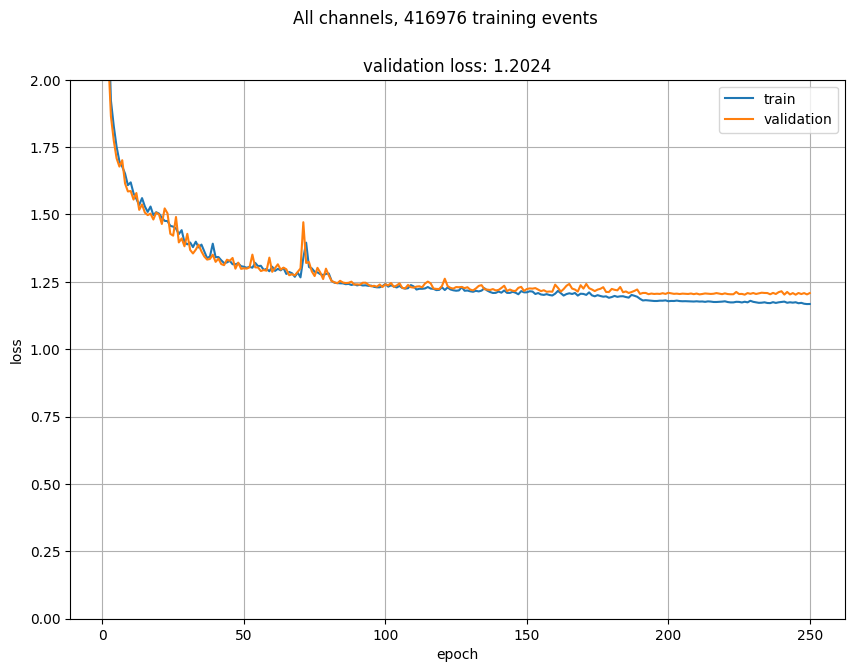

In [18]:
model = create_model(filters_mult=4)

history = train_model(model, X_all_train, Y_all_heatmap_train, X_all_test, Y_all_heatmap_test, lr=0.01, name=f'model_all_channels', 
                      batch_size=16384, train=False, n_epochs=250, verbose=1, loss_weights=100, lr_patience=10, es_patience=25)

plot_history(history, f"All channels, {len(X_all_train)} training events", ymax=2, figsize=(10, 7))

In [19]:
improvements = {}
for channel, (X, y) in list(all_channels_data.items()):
    X_aug, y_aug = augmentation_random_cut(X, y, 8, seed=42, apply=True)
    _, X_test, _, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

    improvement, _, std_model = compare_model_with_cfd(model, cfd, X_test, y_test, channel, show=False)
    improvements[channel] = (improvement, std_model)

1/1 [==============================] - 0s 114ms/step


CFD: 0.453, NN: 0.773 (0.071 ns vs 0.121 ns)
Improvement: -70.67 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.458, NN: 0.713 (0.072 ns vs 0.111 ns)
Improvement: -55.62 %
1/1 [==============================] - 0s 11ms/step


CFD: 0.407, NN: 0.581 (0.064 ns vs 0.091 ns)
Improvement: -42.73 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.423, NN: 0.659 (0.066 ns vs 0.103 ns)
Improvement: -55.84 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.779, NN: 1.129 (0.122 ns vs 0.176 ns)
Improvement: -44.84 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.751, NN: 1.164 (0.117 ns vs 0.182 ns)
Improvement: -55.01 %
1/1 [==============================] - 0s 14ms/step


CFD: 0.442, NN: 0.960 (0.069 ns vs 0.150 ns)
Improvement: -117.30 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.459, NN: 0.808 (0.072 ns vs 0.126 ns)
Improvement: -76.19 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.441, NN: 0.978 (0.069 ns vs 0.153 ns)
Improvement: -121.52 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.560, NN: 0.924 (0.088 ns vs 0.144 ns)
Improvement: -64.93 %
1/1 [==============================] - 0s 11ms/step


CFD: 0.430, NN: 0.781 (0.067 ns vs 0.122 ns)
Improvement: -81.57 %
1/1 [==============================] - 0s 11ms/step


CFD: 0.427, NN: 0.803 (0.067 ns vs 0.125 ns)
Improvement: -87.95 %
1/1 [==============================] - 0s 11ms/step


CFD: 0.410, NN: 0.744 (0.064 ns vs 0.116 ns)
Improvement: -81.40 %
1/1 [==============================] - 0s 14ms/step


CFD: 0.409, NN: 0.792 (0.064 ns vs 0.124 ns)
Improvement: -93.73 %
2/2 [==============================] - 0s 250ms/step


CFD: 0.598, NN: 0.735 (0.093 ns vs 0.115 ns)
Improvement: -22.87 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.683, NN: 0.947 (0.107 ns vs 0.148 ns)
Improvement: -38.70 %
1/1 [==============================] - 0s 11ms/step


CFD: 0.768, NN: 1.031 (0.120 ns vs 0.161 ns)
Improvement: -34.23 %
2/2 [==============================] - 0s 122ms/step


CFD: 0.709, NN: 0.678 (0.111 ns vs 0.106 ns)
Improvement: 4.33 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.487, NN: 0.845 (0.076 ns vs 0.132 ns)
Improvement: -73.48 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.444, NN: 1.018 (0.069 ns vs 0.159 ns)
Improvement: -129.14 %
1/1 [==============================] - 0s 14ms/step


CFD: 0.468, NN: 0.858 (0.073 ns vs 0.134 ns)
Improvement: -83.32 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.509, NN: 0.806 (0.079 ns vs 0.126 ns)
Improvement: -58.58 %


In [20]:
channels = improvements.keys()
precision_data = [f'{std_model * 1000:0.1f}' for _, std_model in improvements.values()]
improvement_data = [f'{improv * 100:0.0f} %' for improv, _ in improvements.values()]

df = pd.DataFrame({'precision [ps]': precision_data, 'improvement': improvement_data}, index=channels)
df.index.name = 'channel'
df

,precision [ps],improvement
channel,,
8,120.8,-71 %
9,111.4,-56 %
10,90.8,-43 %
11,102.9,-56 %
13,176.3,-45 %
14,181.9,-55 %
16,150.1,-117 %
17,126.3,-76 %
18,152.8,-122 %
